## PPCA

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Gaussian Process
import GPy

# PPCA
import edward as ed

In [2]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)
    print("True principal axes:")
    print(w)
    return x_train

N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

x_train = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.18969273]
 [-0.9083446 ]]


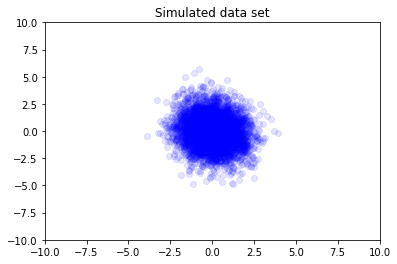

In [3]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

In [4]:
from edward.models import Normal

tf.reset_default_graph()
sess = tf.InteractiveSession()
sess.as_default()

w = Normal(loc=tf.zeros([D, K]), scale=2.0 * tf.ones([D, K]))
z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
x = Normal(loc=tf.matmul(w, z, transpose_b=True), scale=tf.ones([D, N]))

qw = Normal(loc=tf.get_variable("qw/loc", [D, K]), scale=tf.nn.softplus(tf.get_variable("qw/scale", [D, K])))
qz = Normal(loc=tf.get_variable("qz/loc", [N, K]), scale=tf.nn.softplus(tf.get_variable("qz/scale", [N, K])))

In [5]:
inference = 0

inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
inference.run(n_iter=500, n_print=100, n_samples=10)


500/500 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 15799.655


In [6]:
sess = ed.get_session()
print("Inferred principal axes:")
print(sess.run(qw.mean()))

Inferred principal axes:
[[ 0.16981199]
 [-0.91579664]]


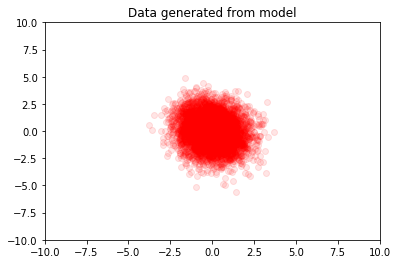

In [7]:
x_post = ed.copy(x, {w: qw, z: qz})
x_gen = sess.run(x_post)

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()

## Import Dataset

### Feature Extracted Dataset

In [14]:
x_train = np.loadtxt('../Data/UCI HAR Dataset/train/X_train.txt')
x_test = np.loadtxt('../Data/UCI HAR Dataset/test/X_test.txt')

subject_train = np.loadtxt('../Data/UCI HAR Dataset/train/subject_train.txt')
subject_test = np.loadtxt('../Data/UCI HAR Dataset/test/subject_test.txt')

y_train = np.loadtxt('../Data/UCI HAR Dataset/train/y_train.txt')
y_test = np.loadtxt('../Data/UCI HAR Dataset/test/y_test.txt')

print x_train.shape
print x_test.shape

(7352, 561)
(2947, 561)


### Raw Feature Dataset

In [9]:
raw_train_directory = os.listdir('../Data/UCI HAR Dataset/train/Inertial Signals')
raw_test_directory = os.listdir('../Data/UCI HAR Dataset/test/Inertial Signals')

# Training Data
x_train_raw = np.array([])
for raw_file in raw_train_directory:
    curr_raw = np.loadtxt('../Data/UCI HAR Dataset/train/Inertial Signals/' + raw_file)
    curr_raw = np.expand_dims(curr_raw, axis=2)
    
    if x_train_raw.size == 0:
        x_train_raw = curr_raw
    else:
        x_train_raw = np.concatenate((x_train_raw, curr_raw), axis=2)

print x_train_raw.shape


# Testing Data
x_test_raw = np.array([])
for raw_file in raw_test_directory:
    curr_raw = np.loadtxt('../Data/UCI HAR Dataset/test/Inertial Signals/' + raw_file)
    curr_raw = np.expand_dims(curr_raw, axis=2)
    
    if x_test_raw.size == 0:
        x_test_raw = curr_raw
    else:
        x_test_raw = np.concatenate((x_test_raw, curr_raw), axis=2)

print x_test_raw.shape


(7352, 128, 9)
(2947, 128, 9)


### Train GP Regression

In [10]:
x_dim = x_train.shape[1]

K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=x_dim, num_outputs=x_dim, kernel=K)

multkernel = K.prod(B,name='B.K')
print multkernel

 /Users/Ardywibowo/anaconda2/envs/ml/lib/python2.7/site-packages/GPy/util/multioutput.py:56: UserWarning:kernel's input dimension overwritten to fit input_dim parameter.


NameError: name 'B' is not defined

1.0